# Windfields

This notebook is for downloading typhoon tracks from
IBTrACS and generating the windfields.

In [1]:
%load_ext jupyter_black

In [2]:
from pathlib import Path
import os

from climada.hazard import Centroids, TCTracks, TropCyclone
from shapely.geometry import LineString
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr

In [3]:
DEG_TO_KM = 111.1  # Convert 1 degree to km
input_dir = Path(os.getenv("STORM_DATA_DIR")) / "analysis/02_new_model_input"

## Get typhoon data

Typhoon IDs from IBTrACS are taken from
[here](https://ncics.org/ibtracs/index.php?name=browse-name)

In [4]:
# Import list of typhoons to a dataframe
typhoons_df = pd.read_csv(input_dir / "01_windfield/typhoons.csv")
typhoons_df

,typhoon_id,typhoon_name,typhoon_year
0,2006329N06150,DURIAN,2006
1,2008169N08135,FENGSHEN,2008
2,2009268N14128,KETSANA,2009
3,2010191N12138,CONSON,2010
4,2011266N13139,NESAT,2011
5,2012331N03157,BOPHA,2012
6,2013282N14132,NARI,2013
7,2013301N13142,KROSA,2013
8,2013306N07162,HAIYAN,2013
9,2013259N17132,USAGI,2013


In [5]:
# Download all tracks from the west pacific basin
sel_ibtracs = TCTracks.from_ibtracs_netcdf(
    provider="usa", year_range=(2006, 2022), basin="WP"
)
sel_ibtracs.size

2022-12-06 13:29:00,894 - climada.hazard.tc_tracks - WARNING - 18 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


494

In [6]:
# Get_track returns the first matching track based
# on the track ID. Interpolate from 3 hours to
# 30 minute intervals to create a smooth intensity field.
tc_tracks = TCTracks()
for typhoon_id in typhoons_df["typhoon_id"]:
    tc_track = sel_ibtracs.get_track(typhoon_id)
    tc_track = tc_track.interp(
        time=pd.date_range(
            tc_track.time.values[0], tc_track.time.values[-1], freq="30T"
        )
    )
    tc_tracks.append(tc_track)

display(tc_tracks.data[:1])

[<xarray.Dataset>
 Dimensions:                 (time: 733)
 Coordinates:
     lat                     (time) float64 6.1 6.118 6.137 ... 11.66 11.68 11.7
     lon                     (time) float64 149.8 149.7 149.6 ... 81.93 81.8
   * time                    (time) datetime64[ns] 2006-11-24T12:00:00 ... 200...
 Data variables:
     time_step               (time) float64 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0
     radius_max_wind         (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
     radius_oci              (time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
     max_sustained_wind      (time) float64 15.0 15.0 15.0 ... 15.0 15.0 15.0
     central_pressure        (time) float64 1.006e+03 1.006e+03 ... 1.006e+03
     environmental_pressure  (time) float64 1.008e+03 1.008e+03 ... 1.006e+03
     basin                   (time) <U2 'WP' 'WP' 'WP' 'WP' ... 'NI' 'NI' 'NI'
 Attributes:
     max_sustained_wind_unit:  kn
     central_pressure_unit:    mb
     name:                     DURIA

<GeoAxesSubplot:>

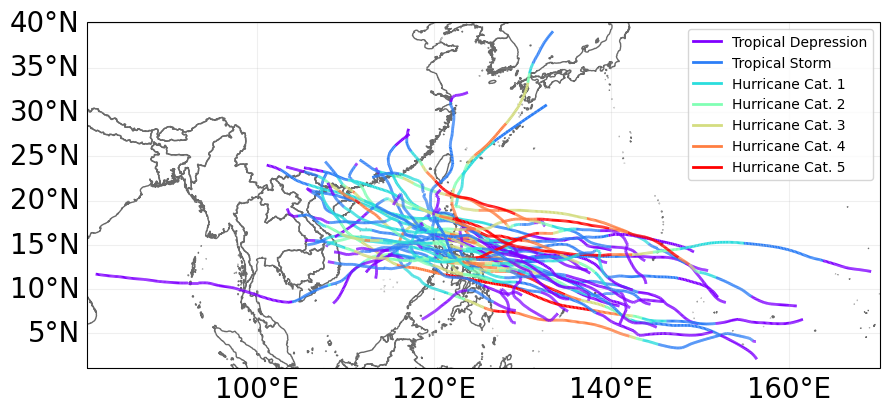

In [7]:
# Plot the tracks
# Takes a while, especially after the interpolation.
tc_tracks.plot()

## Construct the windfield

The typhoon tracks will be used to construct the wind field.
The wind field grid will be set using a geopackage file that is
used for all other grid-based data.

In [8]:
# input_dir = (Path(os.getenv("STORM_DATA_DIR"))/ "analysis/02_new_model_input/input")
# filepath = input_dir / "phl_0.1_degree_grid_centroids.gpkg"
# gdf = gpd.read_file(filepath)

filepath = (
    input_dir
    / "02_housing_damage/output/phl_0.1_degree_grid_centroids_land_overlap.gpkg"
)
gdf = gpd.read_file(filepath)
gdf["id"] = gdf["id"].astype(int)

gdf

,id,Longitude,Latitude,Centroid,geometry
0,101,114.3,11.1,114.3E_11.1N,POINT (114.30000 11.10000)
1,4475,116.9,7.9,116.9E_7.9N,POINT (116.90000 7.90000)
2,4639,117.0,8.2,117.0E_8.2N,POINT (117.00000 8.20000)
3,4640,117.0,8.1,117.0E_8.1N,POINT (117.00000 8.10000)
4,4641,117.0,8.0,117.0E_8.0N,POINT (117.00000 8.00000)
...,...,...,...,...,...
3721,20677,126.6,7.6,126.6E_7.6N,POINT (126.60000 7.60000)
3722,20678,126.6,7.5,126.6E_7.5N,POINT (126.60000 7.50000)
3723,20679,126.6,7.4,126.6E_7.4N,POINT (126.60000 7.40000)
3724,20680,126.6,7.3,126.6E_7.3N,POINT (126.60000 7.30000)


2022-12-06 13:29:33,299 - climada.util.plot - WARNING - Error parsing coordinate system 'epsg:4326'. Using projection PlateCarree in plot.


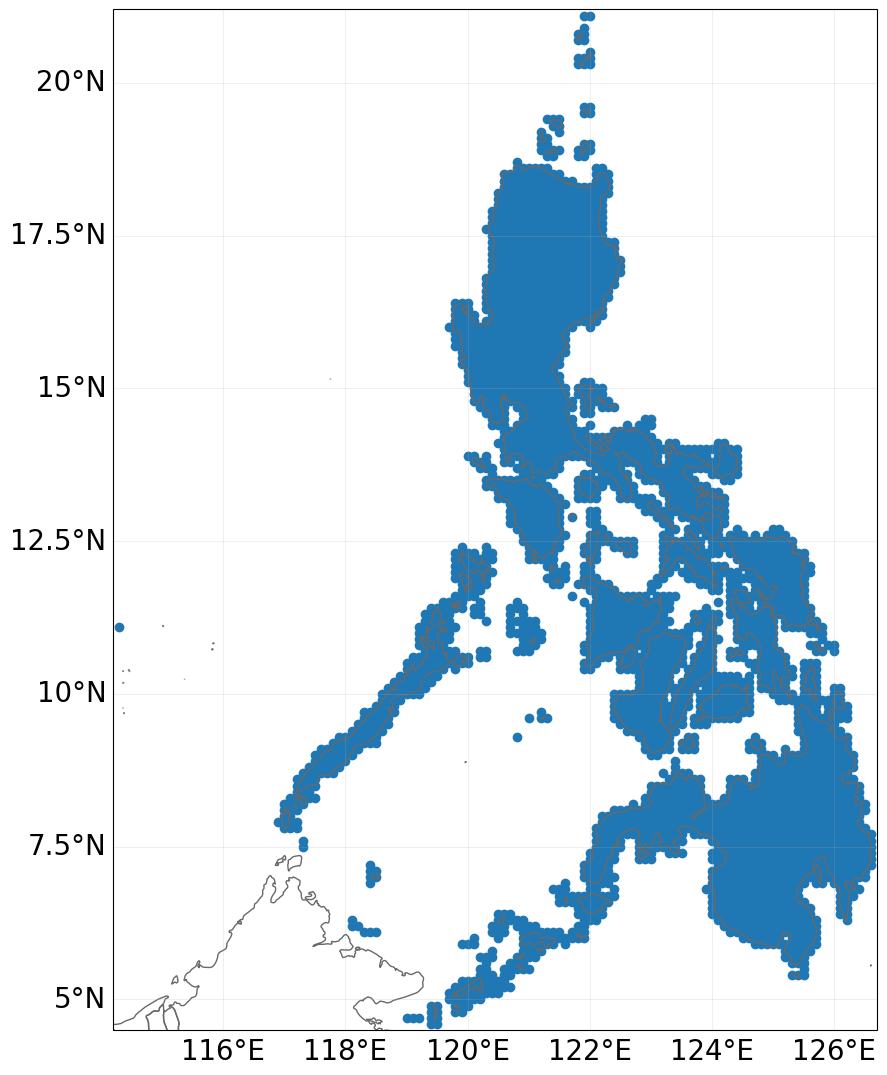

In [9]:
# multipolygon data to centroids

cent = Centroids.from_geodataframe(gpd.read_file(filepath))

cent.check()
cent.plot();

In [10]:
# Consider wind speeds lower than 17.5, which is the
# division between a TD and a TS.
tc = TropCyclone.from_tracks(
    tc_tracks, centroids=cent, store_windfields=True, intensity_thres=0
)

2022-12-06 13:29:45,734 - climada.util.plot - WARNING - Error parsing coordinate system 'epsg:4326'. Using projection PlateCarree in plot.


<GeoAxesSubplot:title={'center':'Event ID 36: 2020299N11144'}>

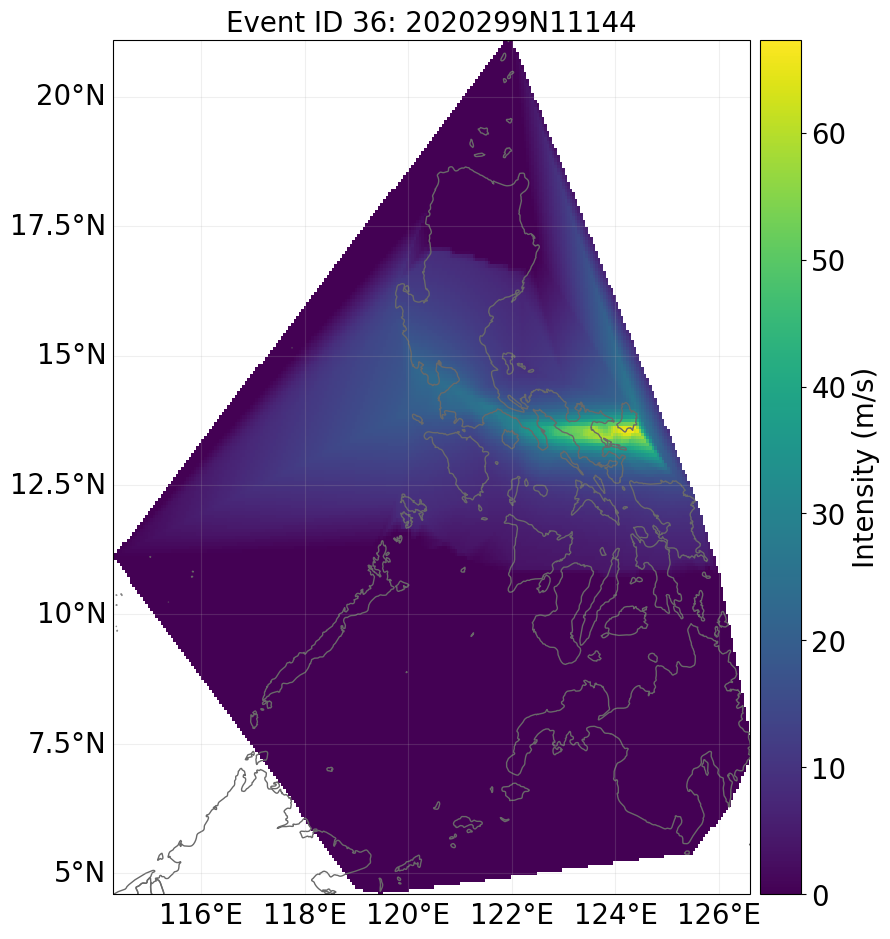

In [11]:
# Let's look at a specific typhoon as an example.
# It looks weird but I think it's just a
# projection issue, as the parts on land look fine
example_typhoon_id = "2020299N11144"  # Goni 2020
# example_typhoon_id = "2019354N05151"  # Phanfone
tc.plot_intensity(example_typhoon_id)

## Save the windfields

Need to extract the windfield per typhoon, and
save it in a dataframe along with the grid points

In [12]:
df_windfield = pd.DataFrame()

for intensity_sparse, event_id in zip(tc.intensity, tc.event_name):
    # Get the windfield
    windfield = intensity_sparse.toarray().flatten()
    npoints = len(windfield)
    typhoon_info = typhoons_df[typhoons_df["typhoon_id"] == event_id]
    # Get the track distance
    tc_track = tc_tracks.get_track(track_name=event_id)
    tc_track_line = LineString(gpd.points_from_xy(tc_track.lon, tc_track.lat))
    # TODO: Not sure that curvature is taken into account in this
    # calculation, i.e. might be missing cos(lat) term. Since we're
    # close to the equator in this case it doesn't matter.
    tc_track_distance = gdf["geometry"].apply(
        lambda point: point.distance(tc_track_line) * DEG_TO_KM
    )
    # Add to DF
    df_to_add = pd.DataFrame(
        dict(
            typhoon_id=[event_id] * npoints,
            typhoon_name=[typhoon_info["typhoon_name"].values[0]] * npoints,
            typhoon_year=[typhoon_info["typhoon_year"].values[0]] * npoints,
            grid_point_id=gdf["id"],
            wind_speed=windfield,
            track_distance=tc_track_distance,
        )
    )
    df_windfield = pd.concat([df_windfield, df_to_add], ignore_index=True)
df_windfield

,typhoon_id,typhoon_name,typhoon_year,grid_point_id,wind_speed,track_distance
0,2006329N06150,DURIAN,2006,101,0.0,303.180555
1,2006329N06150,DURIAN,2006,4475,0.0,638.027502
2,2006329N06150,DURIAN,2006,4639,0.0,603.631997
3,2006329N06150,DURIAN,2006,4640,0.0,614.675270
4,2006329N06150,DURIAN,2006,4641,0.0,625.720905
...,...,...,...,...,...,...
145309,2020296N09137,MOLAVE,2020,20677,0.0,644.575831
145310,2020296N09137,MOLAVE,2020,20678,0.0,655.685233
145311,2020296N09137,MOLAVE,2020,20679,0.0,666.794635
145312,2020296N09137,MOLAVE,2020,20680,0.0,677.904037


## Sanity checks

<AxesSubplot:>

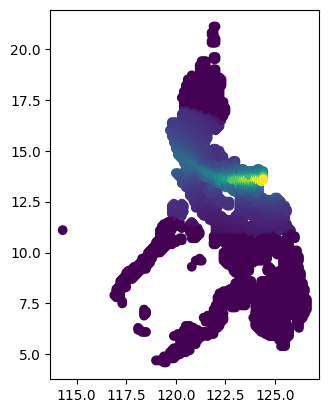

In [13]:
# Check that that the grid points match for the example typhoon.
# Looks good to me!
df_example = df_windfield[df_windfield["typhoon_id"] == example_typhoon_id]
gdf_example = gdf.merge(df_example, left_on="id", right_on="grid_point_id")
gdf_example.plot(c=gdf_example["wind_speed"])

<AxesSubplot:xlabel='track_distance', ylabel='wind_speed'>

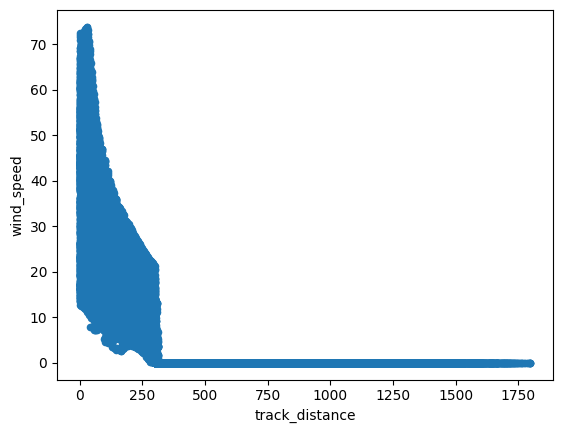

In [14]:
# Plot wind speed against track distance
df_windfield.plot.scatter("track_distance", "wind_speed")

## Save everything

In [15]:
# Save df as a csv file
df_windfield.to_csv(input_dir / "01_windfield/windfield_data.csv")